<a href="https://colab.research.google.com/github/MatheusOrange211/Bootcamp-Alura/blob/main/Modulo_6_Machine_Learning_Modelos%2C_M%C3%A9tricas_e_Valida%C3%A7%C3%A3o_Progresso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No sexto e último módulo, iremos continuar os trabalhos desenvolvidos com os dados do Sírio Libanês que foram apresentados no Módulo 5 e que estão presentes no notebook do [Kaggle](https://www.kaggle.com/matheusnaranjo/modulo-5-machine-learning) (mesmo que não completos). Entenderemos mais sobre os modelos, as formas de medir sua capacidade, suas pontuações, seus parâmetros, métodos e outras coisas importantes para decidir em uma criação de modelo.

# IMPORTANDO BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#DADOS

In [2]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

#AULA 1 : WORKFLOW DE MACHINE LEARNING
---

Abaixo, importaremos alguns códigos usados no módulo passado que contêm as informações que já trabalhamos anteriormente.

Essa função era a responsável por preencher as coluns com dados faltantes pelos os dados anteriores e posteriores para cada grupo de paciente, dado que dados clinicos não mudam com muita variancia.

In [3]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

Essa coluna removia todas as linhas que possuiam valores onde a janela era de até duas horas e o valor para ICU era igual a 1. Ainda dropava dados NaN restantes que fossem gerados.

In [4]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Essa função agrupa todos os grupos de dados de um paciente e atribui o valor ICU == 1 na janela de até duas horas para assim pordemos trabalhar apenas com pacientes do quadro de até duas horas. Eis o motivo de termos jogado fora dados de pacientes com ICU = 1 e WINDOW = 0-2 logo de cara. Se a pessoa já entrou no hospital precisando de UTI, seus dados não servirão para o modelo.

In [5]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes #transformar dados do tipo String para categóricos 
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

Iniciamos a importação e treinamento de dados, dropando do  modelo as colunas ICU e WINDOW

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(73246)


x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

A acurácia deste primeiro treinamento

In [7]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
acuracia_logistico =accuracy_score(y_test, y_prediction)

print(f"MODELO LOGISTIC CLASSIFIER - ACCURACY {(acuracia_logistico*100 ):.2f} % ")

MODELO LOGISTIC CLASSIFIER - ACCURACY 68.18 % 


Colunas que possuem valores do tipo STRING. Precisarão ser transformados pra float de algum modo

In [8]:
dados_describe_columns = dados.describe().columns

for coluna in dados.columns:
    if coluna not in dados_describe_columns:
        print(coluna)

AGE_PERCENTIL
WINDOW


### 📒 Desafio 01 :Transformar a coluna AGE_PERCENTIL em dados categóricos, mas utilizando outro método

Uma outra forma de transformar nossos dados para categóricos é usando o **pd.get_dummies()**. Cada valor de uma coluna se transformará em uma coluna onde teremos valores :
* 0 - aquela linha não possui este valor
* 1 - aquela linha possui este valor

In [9]:
exemplo = pd.DataFrame({"mes":['jan','Fev','Jan','Mar'],"valor":[1000,5000,2000,6000]})
exemplo

,mes,valor
0,jan,1000
1,Fev,5000
2,Jan,2000
3,Mar,6000


Ficando assim:

In [10]:
pd.get_dummies(exemplo)

,valor,mes_Fev,mes_Jan,mes_Mar,mes_jan
0,1000,0,0,0,1
1,5000,1,0,0,0
2,2000,0,1,0,0
3,6000,0,0,1,0


Uma outra forma é usar a Biblioteca Sklearn. Importando preprocessing e dele a classe LabelEncoder, você primeiramente instancia e aplica fit_transform nos dados que deseja categorizar.

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
x_teste_exemplo = exemplo.mes
y_teste_exemplo = label_encoder.fit_transform(x_teste_exemplo)
exemplo.mes = y_teste_exemplo
exemplo

,mes,valor
0,3,1000
1,0,5000
2,1,2000
3,2,6000


#AULA 2 : MÉTRICAS DE AVALIAÇÃO
---

##Matriz de confusão

vamos usar outro modelo para predição. Até agora, usamos  o **LOGISTIC REGRESSION**, agora vamos usar o **DECISION TREE CLASSIFIER**

In [12]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()                           #instancio o modelo de ML
modelo_arvore.fit(x_train,y_train)                                 # Treino os dados que temos com os resultados de treino
predicao_arvore = modelo_arvore.predict(x_test)                    #tento predizer com os nossos dados de teste
acuracia_arvore = accuracy_score(y_test,predicao_arvore)           #Avalio a acurácia dos valores de teste reais com os da minha predição

print(f"MODELO DECISION TREE CLASSIFIER - ACCURACY {(acuracia_arvore*100 ):.2f} % ")

MODELO DECISION TREE CLASSIFIER - ACCURACY 65.91 % 


Aparentemente, o modelo de Logistic está sendo melhor. Mas só temos uma métrica pra decidir isso, que é a acurácia. Não sabemos como os modelos estão tratando a questão dos valores precisamente. Não temos como avaliar propriamente as coisas apenas por essa métrica. Talvez, com uma matriz de confusão, podemos compreender melhor.
>Em análise preditiva, a matriz de confusão (às vezes também chamada de 'matriz de erro' ou 'tabela de confusão' ) é uma tabela com duas linhas e duas colunas que relata o número de falsos positivos , falsos negativos , verdadeiros positivos e verdadeiros negativos . Isso permite uma análise mais detalhada do que a mera proporção de classificações corretas (precisão). A precisão produzirá resultados enganosos se o conjunto de dados estiver desequilibrado; isto é, quando o número de observações em diferentes classes variam muito. 

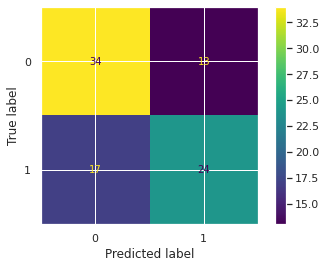

In [13]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(modelo_arvore,x_test,y_test)

* VERDADEIRO POSITIVO (a pessoa precisa de UTI e o modelo acertou) **(VP)** = 24<br>
* VERDADEIRO NEGATIVO (Acerto quando a pessoa não precisa de UTI)**(VN)** = 34<br> 
* FALSO POSITIVO (Quando minha label é zero mas meu modelo diz que é 1) **(FP)** = 13<br>
* FALSO NEGATIVO (Quando minha label é um mas meu modelo diz que é 0) **(FN)** = 17

A partir disso, podemos utilizar em várias métricas para nos aprofundarmos mais e buscar uma precisão melhor e uma avaliação melhor como faremos agora.

<img src="https://miro.medium.com/max/550/1*t1vf-ofJrJqtmam0KSn3EQ.png">

[link para leitura](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c#:~:text=O%20recall%20pode%20ser%20usada,prejudiciais%20que%20os%20Falsos%20Positivos.&text=O%20F1%2DScore%20%C3%A9%20simplesmente,e%20recall%20em%20alguma%20situa%C3%A7%C3%A3o.) Sobre Métricas de Avaliação e qual é a melhor para diferentes casos.

fazendo as contas na mao, temos:

In [14]:
vp = 24
vn = 34
fp = 13
fn = 17

In [15]:
ACURACIA = ( vp + vn )/ (vp + fp + vn + fn)
PRECISAO = vp / (vp + fp)
RECALL = vp /(vp + fn)
F1_SCORE = (2 *(PRECISAO * RECALL))/ (PRECISAO + RECALL)


print(f"Acuracia:{ACURACIA*100}\tPrecisao: {PRECISAO*100}\n\
Recall:{RECALL*100}\tF1 Score: {F1_SCORE*100}")

Acuracia:65.9090909090909	Precisao: 64.86486486486487
Recall:58.536585365853654	F1 Score: 61.53846153846153


Usando o Sklearn, temos:

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predicao_arvore)) #TREE

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



In [17]:
print(classification_report(y_test,y_prediction)) #LOGISTIC

              precision    recall  f1-score   support

           0       0.69      0.74      0.71        47
           1       0.68      0.61      0.64        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



##Curvas ROC e AOC

In [18]:
from sklearn.metrics import roc_auc_score

proba_arvore = modelo_arvore.predict_proba(x_test)
roc_auc_score(y_test,proba_arvore[:,1])

0.6543850544888428

Vamos definir um modelo para separar os dados em treino e teste e o modelo usado.

In [19]:
def roda_modelo(modelo, dados):

  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  
  modelo.fit(x_train, y_train)

  predicao = modelo.predict(x_test)
  prob_predic = modelo.predict_proba(x_test)
  
  auc = roc_auc_score(y_test,prob_predic[:,1])
  print(f"AUC: {auc}")
  print("\nClassification Report")
  print(classification_report(y_test,predicao))

In [20]:
roda_modelo(modelo_arvore,dados_limpos)

AUC: 0.6193565127140633

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



In [21]:
roda_modelo(modelo,dados_limpos)

AUC: 0.7410482615464452

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



### 📒 Desafio 02: Verificar o impacto da mudança nos resultados.

### 📒 Desafio 03: Pesquisar sobre F-score.

> O F1-Score é simplesmente uma maneira de observar somente 1 métrica ao invés de duas (precisão e recall) em alguma situação. É uma média harmônica entre as duas, que está muito mais próxima dos menores valores do que uma média aritmética simples. Ou seja, quando tem-se um F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo.

<img src="https://miro.medium.com/max/2400/1*V_TXxdVdDofCXEw9yB-JUg.png">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png">

### 📒 Desafio 04: Pesquisar e plotar a arvore de decisão criada pelo modelo.

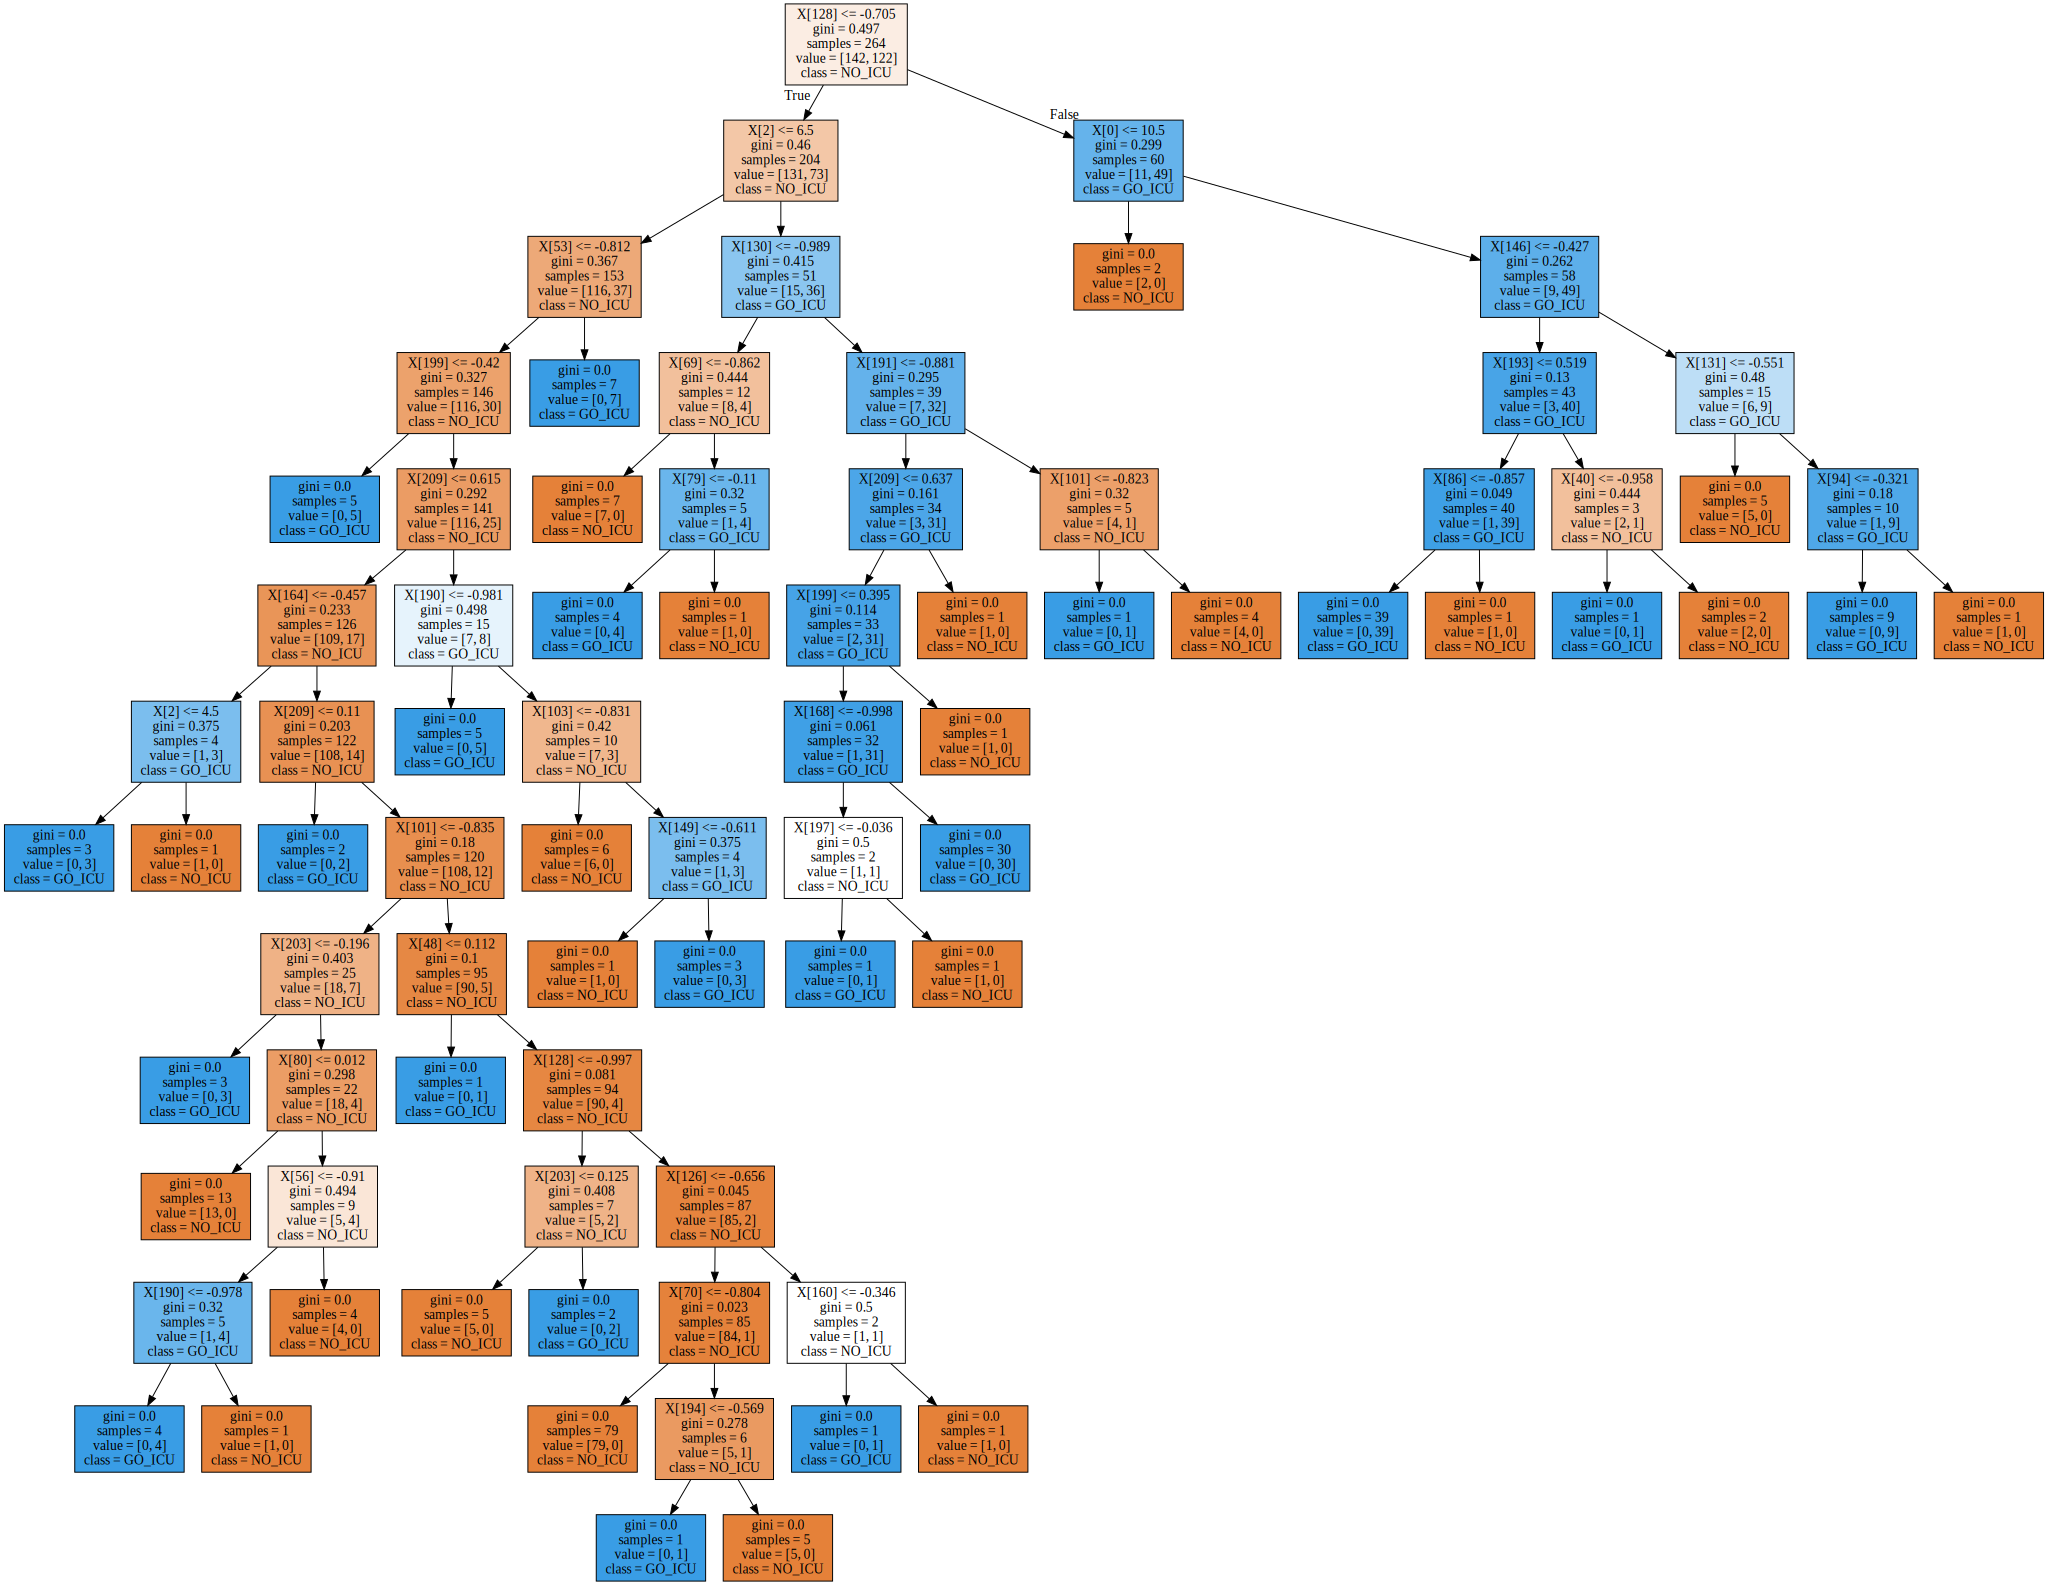

<Figure size 864x360 with 0 Axes>

In [22]:
from sklearn.tree import  export_graphviz
import pydotplus
import graphviz
from google.colab import files

fig = plt.figure(figsize=(12,5))
dot_data = export_graphviz(modelo_arvore,out_file=None,
                           class_names=['NO_ICU','GO_ICU'],
                           filled=True)


 
# fig.savefig("decistion_tree.png")
graph = graphviz.Source(dot_data, format="svg")
graph.render("decision_tree_graphivz")
graph

### 📒 Desafio 05: Criar uma função que gere a curva ROC.

In [23]:
import sklearn.metrics as metrics

def roc_plot(modelo_lista,x_test,y_test):
  for modelo in modelo_lista:
    probs = modelo.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test,preds)
    #tpr = true positive rate Taxa de verdadeiro positivo (True Positive Rate),
    #que é dado por true positives / (true positives + false negatives)

    #fpr = Taxa de falso positivo (False Positive Rate), 
    #que é dado por false positives / (false positives + true negatives)

    roc_auc = metrics.auc(fpr,tpr)

    plt.figure(figsize=(12,6))    
    plt.title(f"ROC - {modelo.__class__.__name__}")
    plt.plot(fpr,tpr,'b',label=f'MODELO {modelo.__class__.__name__} - AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.ylabel('TRUE POSITIVE RATE')
    plt.xlabel('FALSE POSITIVE RATE')
   

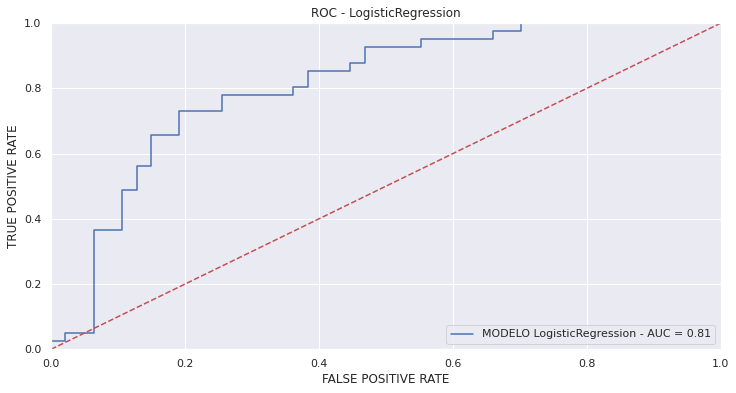

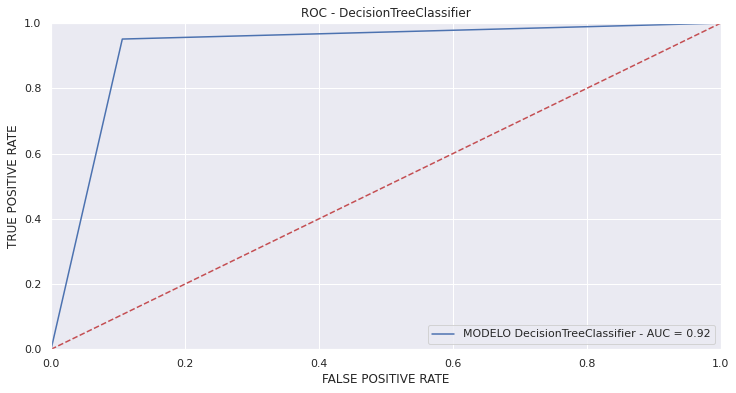

In [24]:
lista = [modelo, modelo_arvore]
roc_plot(lista,x_test,y_test)

### 📒 Desafio 06: Pensar e tentar diminuir o efeito de aleatoriedade nas previsões.



#AULA 3 : ALEATORIEDADE DE MODELOS
---

vamos buscar então reduzir a aleatoriedade dos modelos
O que acontece é que temos um problema em relação a aletoriedade de quantos porcento nosso modelo está indo bem. Com essa função, podemo visualizar como nosso modelo irá performar após rodar n vezes. Ainda teremos um invertavalo, do valor minimo até o valor máximo que aquele modelo está indo. Diminuimos assim a discrepancia de aleatoriedade

In [25]:
def roda_n_modelos(modelo, dados,n):

  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  auc_list = []

  for _ in range(0,n):
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
    modelo.fit(x_train, y_train)
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test,prob_predic[:,1])
    auc_list.append(auc)

  auc_medio = np.mean(auc_list)
  auc_std = np.std(auc_list)
  print(f"AUC: {auc_medio}\t STD: {auc_std}\n\nINTERVALO: {auc_medio - 2 * auc_std} - {auc_medio + 2 * auc_std} ")


Modelo de arvore

In [26]:
roda_n_modelos(modelo_arvore,dados_limpos,50)

AUC: 0.6309289050337312	 STD: 0.04787978644401745

INTERVALO: 0.5351693321456963 - 0.7266884779217662 


In [27]:
roda_n_modelos(modelo_arvore,dados_limpos,50)

AUC: 0.6297145822522056	 STD: 0.03778534021832129

INTERVALO: 0.554143901815563 - 0.7052852626888482 


Modelo logistico - É mais longo que o de arvore

In [28]:
roda_n_modelos(modelo,dados_limpos,50)

AUC: 0.7537934613388687	 STD: 0.041036963996394976

INTERVALO: 0.6717195333460788 - 0.8358673893316586 


In [29]:
roda_n_modelos(modelo,dados_limpos,50)

AUC: 0.7639750908147378	 STD: 0.043914912700793736

INTERVALO: 0.6761452654131503 - 0.8518049162163253 


### 📒 Desafio 07: Estudar a documentação do sklearn e testar outros modelos.

#AULA 4 : VALIDAÇÃO CRUZADA
---

Estamos treinando as coisas e tudo parece ir muito bem. Contudo, há uma questão que pode passar despercebida que é o fator de azar.
<br>Quando separamos nossos dados em x_train e y_train por exemplo, podemos acabar passando dados que auxiliariam bem em determinado modelo e por ai vai. Utilizando a chamada **validação cruzada**, podemos treinar todo muito e testar todo mundo com um unico dataset.<br>
 A ideia é dividir nosso conjunto de dados em n-fatias, onde, por exemplo, de 5 fatias, a primeira será a de teste e as demais de treino. Depois, a segunda fatia será a de teste, e as demais de treino, depois a terceira de teste e as demais de treino e por ai vai, até chegar na quinta de teste e as demais fatias de treino.<br>
Cada fatia irá gerar um resultado, seja acurácia, precisão, recall, etc. Caberá a nós, descobrir o que fazer com isso, mas ainda assim, teremos treinado e testado todo mundo certinho. vamos ver:

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5,shuffle=True) #ele irá embaralhar os dados, pra assim, tudo ser separado aleatoriamente
cross_validate(modelo, x, y, cv=cv) #cv = numero de divisoes que queremos

{'fit_time': array([0.56757975, 0.31389618, 0.17460489, 0.64975286, 0.56927276]),
 'score_time': array([0.00255704, 0.00229764, 0.00224376, 0.00227046, 0.00228882]),
 'test_score': array([0.64788732, 0.70422535, 0.67142857, 0.77142857, 0.75714286])}

Podemos também realizar um processo semelhante ao de repetir n vezes o nosso modelo para assim diminuir uma aleatoriedade que possa surgir. Usaremos abaixo:

In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold


cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.23548055, 0.22202754, 0.53410387, 0.16065097, 0.56039858,
        0.1949017 , 0.21838117, 0.18661833, 0.57467961, 0.50674796,
        0.64294362, 0.59286761, 0.52313852, 0.5185461 , 0.56066656,
        0.50710988, 0.50986481, 0.26410651, 0.18949842, 0.53701091,
        0.57142496, 0.61120558, 0.53185129, 0.47201204, 0.58460784,
        0.56055117, 0.57406521, 0.60750103, 0.65541077, 0.23790741,
        0.2013855 , 0.54497528, 0.24278498, 0.45389223, 0.21422577,
        0.50701928, 0.56720757, 0.25977921, 0.49564934, 0.20846272,
        0.56943846, 0.32574582, 0.51486182, 0.69141936, 0.5485158 ,
        0.66444182, 0.24481559, 0.54845285, 0.25264549, 0.64966917]),
 'score_time': array([0.00230432, 0.00230145, 0.00236535, 0.00229764, 0.00234532,
        0.00236654, 0.00234795, 0.00225306, 0.00222754, 0.00233459,
        0.00244164, 0.00257587, 0.00244927, 0.00259876, 0.00233221,
        0.00233603, 0.0022552 , 0.00229621, 0.00228214, 0.00277352,
        0.0024519 , 

Adaptaremos a função roda modelo para uma nova

In [32]:
def roda_modelo_cv(modelo, dados,n_splits,n_repeats):


  np.random.seed(434876)
  #como não temos a opção shuffle aqui,
  #está se torna uma forma de embaralhar dados
  dados = dados.sample(frac=1).reset_index(drop=True) #reseta index gerados


  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv,scoring='roc_auc',return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])
  
  print(f"AUC: {auc_medio} -  {auc_medio_treino}")
  return auc_medio, auc_medio_treino
  # print(f"AUC: {auc_medio}\
  # \nIntervalo: {auc_medio - (2 * auc_std)} - {auc_medio + (2 * auc_std)}")
  

**Modelo LOGISTIC REGRESSION**

> com cross - validation e Repeated Stratified K-Fold

In [33]:
roda_modelo_cv(modelo,dados_limpos,5,10)

AUC: 0.7591737116901591 -  0.8649421285546367


(0.7591737116901591, 0.8649421285546367)

> com fit , predict, roc_auc_score

In [34]:
roda_n_modelos(modelo,dados_limpos,50)

AUC: 0.7530150492994292	 STD: 0.03940161642914456

INTERVALO: 0.67421181644114 - 0.8318182821577184 


Modelo ARVORE

> com cross - validation e Repeated Stratified K-Fold

In [35]:
roda_modelo_cv(modelo_arvore,dados_limpos,5,10)

AUC: 0.6250049571102202 -  1.0


(0.6250049571102202, 1.0)

> com fit , predict, roc_auc_score

In [36]:
roda_n_modelos(modelo_arvore,dados_limpos,50)

AUC: 0.6379968863518424	 STD: 0.044693728115295185

INTERVALO: 0.548609430121252 - 0.7273843425824328 


### 📒 Desafio 08: Testar outros splitter classes e observar as diferenças.

#AULA 5 : DESAFIOS EM MACHINE LEARNING
---

In [37]:
from sklearn.tree import DecisionTreeClassifier

teste_lista = []
treino_lista = []
for i in range(1,15):
  modelo_arvore = DecisionTreeClassifier(max_depth=i)
  teste,treino = roda_modelo_cv(modelo_arvore,dados_limpos,5,10)
  teste_lista.append(teste)
  treino_lista.append(treino)


AUC: 0.5753627580930213 -  0.6462702868167568
AUC: 0.6547482178649942 -  0.7540090621608231
AUC: 0.6708181858593043 -  0.8254718012694471
AUC: 0.6670769012134143 -  0.8852336545445912
AUC: 0.6408893365554549 -  0.9301090648573542
AUC: 0.6311601254364413 -  0.9574896547099648
AUC: 0.6103239094357515 -  0.9744039246449021
AUC: 0.5928434752036725 -  0.984075879002609
AUC: 0.5931051715591189 -  0.9900051874708217
AUC: 0.5881909376481745 -  0.993956725128006
AUC: 0.6049288964502781 -  0.9970944428025339
AUC: 0.614950664629941 -  0.9987030180629718
AUC: 0.6231154696861934 -  0.9995326605684471
AUC: 0.6250192559485321 -  0.9999323195007601


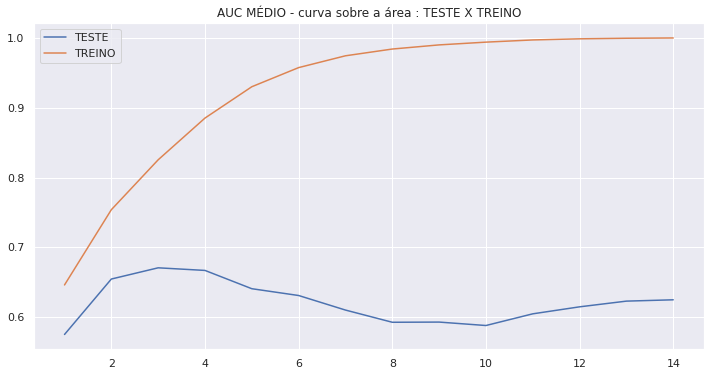

In [38]:
x = range(1,15)

plt.figure(figsize=(12,6))
plt.plot(x,teste_lista)
plt.plot(x,treino_lista)
plt.legend(['TESTE','TREINO'])
plt.title("AUC MÉDIO - curva sobre a área : TESTE X TREINO")
# plt.ylim(0,1)
plt.show()

Ao que tudo indica, temos um **overfiting**. Significa que nossos dados ficaram tão bons para treino que quando generalizados, acabaram não indo muito bem

In [39]:
from sklearn.ensemble import RandomForestClassifier

teste_lista = []
treino_lista = []
for i in range(1,15):
  modelo_random = RandomForestClassifier(max_depth=i)
  teste,treino = roda_modelo_cv(modelo_random,dados_limpos,5,10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC: 0.7747846620543989 -  0.8548634678781238
AUC: 0.7837516299193931 -  0.8977908116650604
AUC: 0.7890382128540022 -  0.9397243510263293
AUC: 0.7909859530583216 -  0.9706763644907691
AUC: 0.793447899155136 -  0.9879102951611647
AUC: 0.7914095973964395 -  0.9959117818861474
AUC: 0.7911027280270702 -  0.9989893030608237
AUC: 0.7895684081210398 -  0.9998268109176044
AUC: 0.7922168250786672 -  0.9999757189913765
AUC: 0.7878131735204102 -  0.999998987854251
AUC: 0.7910251384757965 -  1.0
AUC: 0.7887270935708436 -  1.0
AUC: 0.789928182518643 -  1.0
AUC: 0.7895406186689081 -  1.0


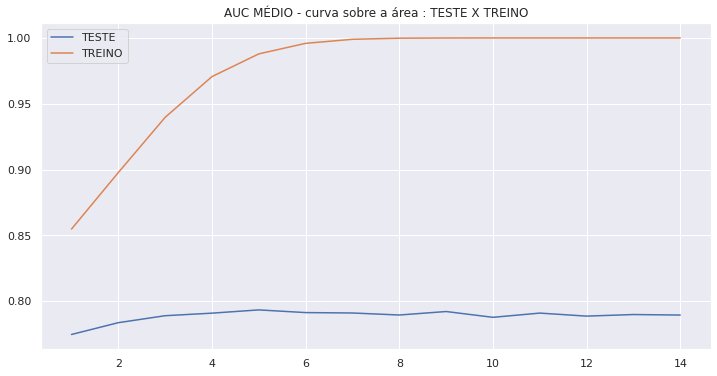

In [40]:
x = range(1,15)

plt.figure(figsize=(12,6))
plt.plot(x,teste_lista)
plt.plot(x,treino_lista)
plt.legend(['TESTE','TREINO'])
plt.title("AUC MÉDIO - curva sobre a área : TESTE X TREINO")
# plt.ylim(0,1)
plt.show()

procurar n_estimador

In [41]:
  modelo_random = RandomForestClassifier(n_estimators=10)
  teste,treino = roda_modelo_cv(modelo_random,dados_limpos,5,10)

AUC: 0.7444428773869564 -  0.9991880101534882


In [42]:
  modelo_random = RandomForestClassifier(n_estimators=100)
  teste,treino = roda_modelo_cv(modelo_random,dados_limpos,5,10)

AUC: 0.7888795516509332 -  1.0


### 📒 Desafio 09: Deixar o gráfico de AUC bonitão.

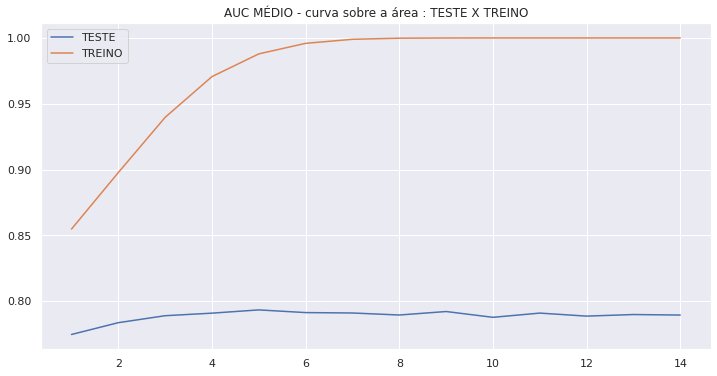

In [43]:
x = range(1,15)

plt.figure(figsize=(12,6))
plt.plot(x,teste_lista)
plt.plot(x,treino_lista)
plt.legend(['TESTE','TREINO'])
plt.title("AUC MÉDIO - curva sobre a área : TESTE X TREINO")
# plt.ylim(0,1)
plt.show()

### 📒 Desafio 10: Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic).

### 📒 Desafio 11: Estudar um pouco mais sobre overfit e underfit.

### 📒 Desafio 12: Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários hiperparâmetros.

In [44]:
from xgboost import XGBClassifier

teste_lista = []
treino_lista = []
for i in range(1,15):
  modelo_XGBClassifier = XGBClassifier(max_depth=i)
  teste,treino = roda_modelo_cv(modelo_XGBClassifier,dados_limpos,5,10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC: 0.7665045503038925 -  0.9169913989357553
AUC: 0.7836546968619337 -  0.9910765798960152
AUC: 0.7877704319151689 -  0.9999675038329628
AUC: 0.7876470295055821 -  1.0
AUC: 0.7884932540195697 -  1.0
AUC: 0.7854901612138455 -  1.0
AUC: 0.7874718603172549 -  1.0
AUC: 0.7874253200568988 -  1.0
AUC: 0.7864063644984697 -  1.0
AUC: 0.7859017899478424 -  1.0
AUC: 0.7866068041725938 -  1.0
AUC: 0.7870470575240313 -  1.0
AUC: 0.7861466819690505 -  1.0
AUC: 0.7864816101987155 -  1.0


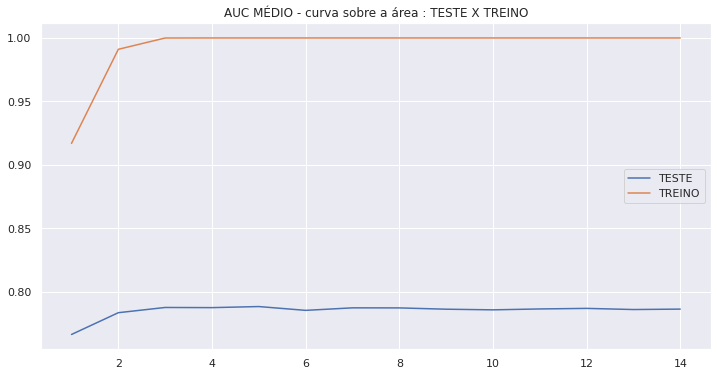

In [45]:
x = range(1,15)

plt.figure(figsize=(12,6))
plt.plot(x,teste_lista)
plt.plot(x,treino_lista)
plt.legend(['TESTE','TREINO'])
plt.title("AUC MÉDIO - curva sobre a área : TESTE X TREINO")
# plt.ylim(0,1)
plt.show()

### 📒 Desafio 13: Pesquisar como salvar um modelo treinado.

#AULA 6 : FINALIZANDO A VALIDAÇÃO
---

removendo features com alta correlação

In [46]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 659.8+ KB


In [47]:
dados_limpos.select_dtypes(exclude='float64')

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


In [48]:
alta_corr = 0.95
matriz_corr = dados_limpos.iloc[:,4:-2].corr().abs()
excluir  = [ coluna for coluna in matriz_corr.columns if any(matriz_corr[coluna] > alta_corr)]

buscaremos escolher as colunas com alta correlação e que serão removidas

In [49]:
excluir

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEDIAN',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEDIAN',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEDIAN',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEDIAN',
 'GLUCOSE_MEAN',
 '

O problema é que fazendo isso, desse modo apenas, iremos excluir basicamente todo o conjunto de dados. Ainda há o fato de que a matriz gerada possuir na diagonal ,valores iguais a um, e de serem espelhados. Uma outra abordagem, mas ainda com a mesma ideia, deve ser feita pra resolver isso.

In [50]:
matriz_corr.shape

(225, 225)

Vamos criar uma matriz com o numpy

In [51]:
np.ones(matriz_corr.shape)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Vamos excluir a diagonal principal e o triangulo inferior

In [52]:
np.triu(np.ones(matriz_corr.shape),k=1)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

em python, 1 == True, lembre-se

In [53]:
np.triu(np.ones(matriz_corr.shape),k=1).astype(np.bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

agora aplica a função `where`do python e assim, pega-se apenas os valores True

In [54]:
matriz_corr.where(np.triu(np.ones(matriz_corr.shape),k=1).astype(np.bool))

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,NaN,0.196347,0.278271,0.017529,0.340370,0.202849,0.489245,0.176224,0.153793,0.009174,0.009174,0.009174,0.009174,NaN,0.030413,0.030413,0.030413,0.030413,NaN,0.104179,0.104179,0.104179,0.104179,NaN,0.013215,0.013215,0.013215,0.013215,NaN,0.072771,0.072771,0.072771,0.072771,NaN,0.046671,0.046671,0.046671,0.046671,NaN,0.020510,...,0.005561,0.005561,0.005561,NaN,0.105965,0.112316,0.015686,0.089330,0.035513,0.025573,0.100418,0.110268,0.033409,0.092466,0.033773,0.031653,0.084358,0.124403,0.021311,0.094510,0.024580,0.037813,0.120437,0.099909,0.032427,0.073348,0.042184,0.008804,0.054710,0.053091,0.129220,0.028964,0.041099,0.056287,0.050070,0.054745,0.093512,0.052568,0.039692,0.056984
DISEASE GROUPING 2,NaN,NaN,0.084392,0.114818,0.112878,0.032173,0.118516,0.139947,0.068432,0.032245,0.032245,0.032245,0.032245,NaN,0.013532,0.013532,0.013532,0.013532,NaN,0.027544,0.027544,0.027544,0.027544,NaN,0.005880,0.005880,0.005880,0.005880,NaN,0.036119,0.036119,0.036119,0.036119,NaN,0.003539,0.003539,0.003539,0.003539,NaN,0.009126,...,0.048981,0.048981,0.048981,NaN,0.095532,0.031352,0.016813,0.020068,0.011225,0.032448,0.112696,0.024483,0.012664,0.021007,0.012416,0.059772,0.093647,0.026938,0.021756,0.019150,0.005121,0.038081,0.070772,0.041188,0.015483,0.018921,0.016164,0.006302,0.046677,0.029821,0.014222,0.001618,0.024705,0.085122,0.070419,0.016917,0.005102,0.003487,0.024682,0.099019
DISEASE GROUPING 3,NaN,NaN,NaN,0.308875,0.293259,0.275760,0.471039,0.075599,0.141903,0.035719,0.035719,0.035719,0.035719,NaN,0.028061,0.028061,0.028061,0.028061,NaN,0.078813,0.078813,0.078813,0.078813,NaN,0.121935,0.121935,0.121935,0.121935,NaN,0.058743,0.058743,0.058743,0.058743,NaN,0.006233,0.006233,0.006233,0.006233,NaN,0.165258,...,0.009263,0.009263,0.009263,NaN,0.046600,0.144381,0.050511,0.052495,0.095023,0.149534,0.055008,0.141602,0.047499,0.043561,0.093179,0.149762,0.039784,0.136814,0.048458,0.060394,0.093307,0.139419,0.044819,0.150604,0.053770,0.049369,0.088511,0.140484,0.005354,0.027667,0.015035,0.013900,0.000746,0.005011,0.004373,0.020683,0.011633,0.008895,0.003183,0.006110
DISEASE GROUPING 4,NaN,NaN,NaN,NaN,0.128287,0.171438,0.136472,0.103100,0.063919,0.049593,0.049593,0.049593,0.049593,NaN,0.012640,0.012640,0.012640,0.012640,NaN,0.051789,0.051789,0.051789,0.051789,NaN,0.005492,0.005492,0.005492,0.005492,NaN,0.072546,0.072546,0.072546,0.072546,NaN,0.028718,0.028718,0.028718,0.028718,NaN,0.008524,...,0.033033,0.033033,0.033033,NaN,0.019144,0.034627,0.034718,0.00

In [55]:
matrix_upper = matriz_corr.where(np.triu(np.ones(matriz_corr.shape),k=1).astype(np.bool))
excluir  = [ coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > alta_corr)]
excluir

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEDIAN',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEDIAN',
 'NEUTROPHILES_MEA

Parece que agora deu finalmente certo

In [56]:
def remove_corr_var(dados,valor_corte = .95):

  matriz_corr = dados.iloc[:,4:-2].corr().abs()
  matrix_upper = matriz_corr.where(np.triu(np.ones(matriz_corr.shape),k=1).astype(np.bool))
  excluir  = [ coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

  return dados.drop(excluir,axis=1)

In [57]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos,.95)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

Feito então as mudanças e exclusões, vamos ver o quanto a falta de certas colunas com alta correlação, irão impactar nos resultados

**Sem a retirada de colunas de alta correlação**

####MODELO ARVORE

**Sem a retirada de colunas de alta correlação**

In [70]:
roda_modelo_cv(modelo_arvore,dados_limpos,5,10)

AUC: 0.6250049571102202 -  1.0


(0.6250049571102202, 1.0)

**Com a retirada de colunas de alta correlação**

In [71]:
roda_modelo_cv(modelo_arvore,dados_limpos_sem_corr,5,10)

AUC: 0.633467727596017 -  1.0


(0.633467727596017, 1.0)

####MODELO LOGISTICO

**Sem a retirada de colunas de alta correlação**

In [72]:
roda_modelo_cv(modelo,dados_limpos,5,10)

AUC: 0.7591737116901591 -  0.8649421285546367


(0.7591737116901591, 0.8649421285546367)

**Com a retirada de colunas de alta correlação**

In [73]:
roda_modelo_cv(modelo,dados_limpos_sem_corr,5,10)

AUC: 0.7638141864951078 -  0.8498845127936329


(0.7638141864951078, 0.8498845127936329)

####MODELO RANDOM FOREST

**Sem a retirada de colunas de alta correlação**

In [74]:
roda_modelo_cv(modelo_random,dados_limpos,5,10)

AUC: 0.7888795516509332 -  1.0


(0.7888795516509332, 1.0)

**Com a retirada de colunas de alta correlação**

In [75]:
roda_modelo_cv(modelo_random,dados_limpos_sem_corr,5,10)

AUC: 0.7989764645027804 -  1.0


(0.7989764645027804, 1.0)

### 📒 Desafio 14: Ler no Sklearn sobre feature selection, feature importance.

### 📒 Desafio 15: Plotar também a matriz de confusão.

### 📒 Desafio 16: Repassar pelo desafio 12, com as bases de dados alteradas.

### 📒 Desafio Extra: Criar um pipeline de treinamento.